# Problem 3

###### Method

We implement a Self-Organizing Map (SOM) trained on two random distributions: a standard random uniform distribution, and a standard random gaussian distribution.

The SOM model was trained on both datasets for 2000 iterations each. The neighborhood function was set to a gaussian, with initial standard deviation starting at 4 units, and decreasing exponentially with time decay of 1/300. Similarly, the learning rate was initially set to 4, and decreases exponentially with time decay 1/300. The original distribution, and the initial and final SOMs for plotted for both distributions. 

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">
<button>Toggle Code</button></a>''')

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# set random seed
np.random.seed(1000)

In [3]:
"""
    Create 100 random points from different distributions
"""
# uniform
uniform = np.random.rand(100,2)

# gaussian
gaussian = np.random.randn(100,2)

In [4]:
"""
    Create SOM
"""
class SOM:
    """
        A self organizing map
    """
    def __init__(self,data_input,lr=300,lt=4,nr=300,nt=4,iterations=2000):
        """
            Initialization
        """
        # store the input
        self.data = data_input
        
        # store learning and neighborhood rate functions
        self.lr = lambda t: lt*np.exp(-t/lr)
        self.nr = lambda t: nt*np.exp(-t/nr)
        
        # store iterations
        self.iterations = iterations
        
        # create the weights
        xx,yy = np.meshgrid(np.linspace(0,0.5,10),np.linspace(0,0.5,10))
        self.w = np.stack((xx,yy),2)
        
        # save initial w
        self.initial_w = np.copy(self.w)
        
        # set neighborhood function (I use a 2D gaussian)
        self.neighborhood = lambda sigma: self.gkern(sig=sigma,n=(2*nt+1))
        
    def train(self):
        """
            Train the SOM
        """ 
        for k in range(self.iterations):
            # choose a random input
            idx = int(np.round(np.random.rand()*99))
            selected_input = self.data[idx,:]

            # Initialize small distance value
            smallest_distance = 999999

            # set initial BMU (best matching unit)
            BMU = (100,100)

            # loop over every node in map
            for i,w_x1 in enumerate(self.w):
                for j,node_weight in enumerate(w_x1):
                    # get L2 norm
                    L2 = np.linalg.norm(node_weight-selected_input,2)

                    # if L2 < smallest distance, then store value and idx
                    if L2 < smallest_distance:
                        smallest_distance = L2
                        BMU = (i,j)

            # Update weight vectors of the nodes in neighborhood of BMU
            # and pull them closer to input vector

            # calculate the difference between BMU and input
            diff = (selected_input - self.w[BMU[0],BMU[1]])

            # update weights in neighborhood
            for n in self.neighborhood(self.nr(k)):
                try:
                    self.w[BMU[0]+n[0],BMU[1]+n[1]] = (self.w[BMU[0]+n[0],BMU[1]+n[1]]
                        + n[2]*self.lr(k)*diff)
                except IndexError:
                    pass
        
        # return weights
        return self.w,self.initial_w
    
    @staticmethod
    def gkern(sig, n):
        """
            creates gaussian kernel look up table
        """
        # create gaussian kernel
        ax = np.arange(-n // 2 + 1., n // 2 + 1.)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
        gk = kernel / np.sum(kernel)
        
        # now create lookup table
        c = int(np.floor(n/2))
        lookup_table = []
        for i in range(n):
            for j in range(n):
                lookup_table.append([i-c,j-c,gk[i,j]])
        return lookup_table

In [5]:
"""
    Create plot function for drawing lattice
"""
def plot_lattice(x):
    # create list to track connections
    track_connections = []
    
    # loop through elements in grid, keeping track of already made connections
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # plot connections in neighborhood of neuron, ignore index errors, and loopbacks
            try:
                if ({i,i+1},{j}) in track_connections:
                    pass
                else:
                    plt.plot([x[i,j,0],x[i+1,j,0]],[x[i,j,1],x[i+1,j,1]],'b',linewidth=0.25)
                    track_connections.append(({i,i+1},{j}))
            except IndexError:
                pass
            try:
                if ({i,i-1},{j}) in track_connections:
                    pass
                elif i == 0:
                    pass
                else:
                    plt.plot([x[i,j,0],x[i-1,j,0]],[x[i,j,1],x[i-1,j,1]],'b',linewidth=0.25)
                    track_connections.append(({i,i-1},{j}))
            except IndexError:
                pass
            try:
                if ({i},{j+1}) in track_connections:
                    pass
                plt.plot([x[i,j,0],x[i,j+1,0]],[x[i,j,1],x[i,j+1,1]],'b',linewidth=0.25)
                track_connections.append(({i},{j,j+1}))
            except IndexError:
                pass
            try:
                if ({i},{j-1}) in track_connections:
                    pass
                elif j == 0:
                    pass
                else:
                    plt.plot([x[i,j,0],x[i,j-1,0]],[x[i,j,1],x[i,j-1,1]],'b',linewidth=0.25)
                    track_connections.append(({i},{j,j-1}))
            except IndexError:
                pass

In [6]:
"""
    Train SOMs
"""
weight_uniform,weight_uniform_initial = SOM(uniform).train()
weight_gaussian,weight_gaussian_initial = SOM(gaussian,lr=3000,nr=3000,iterations=10000).train()

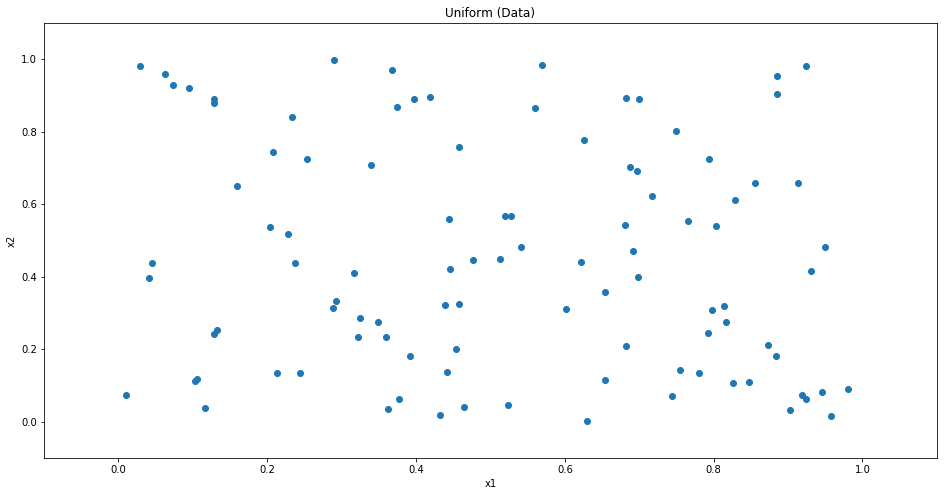

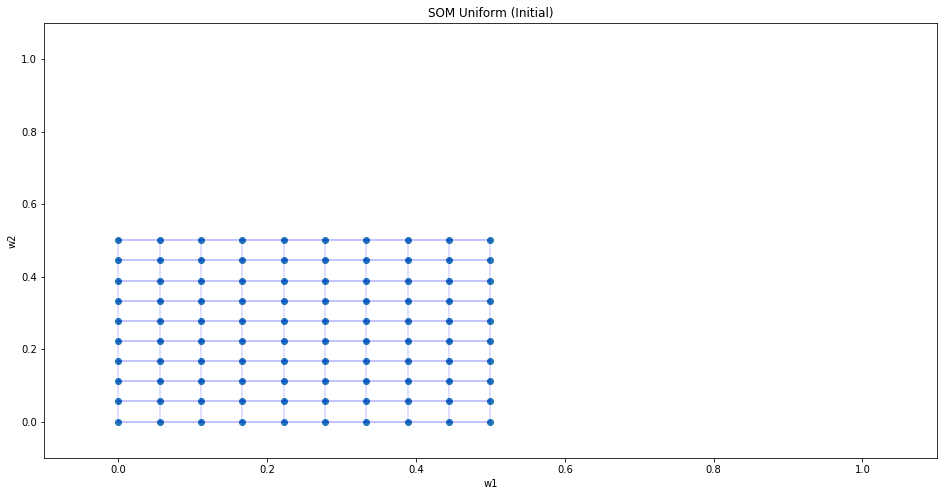

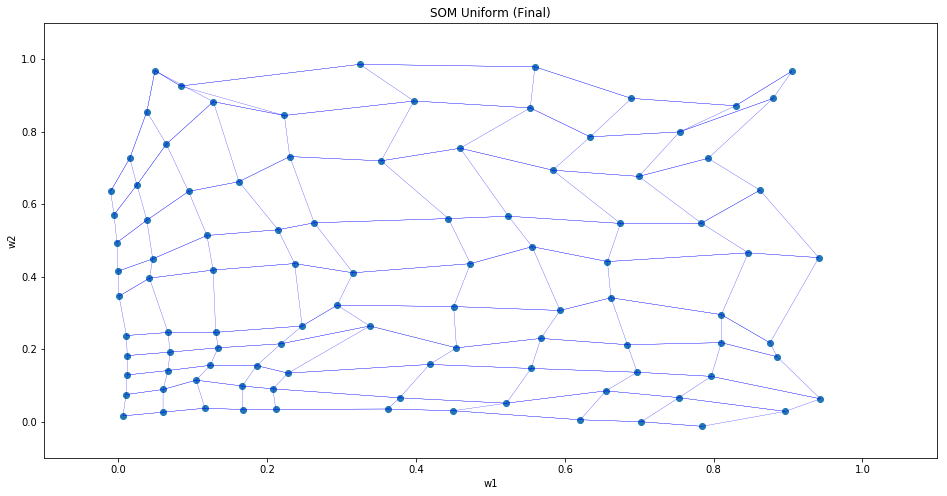

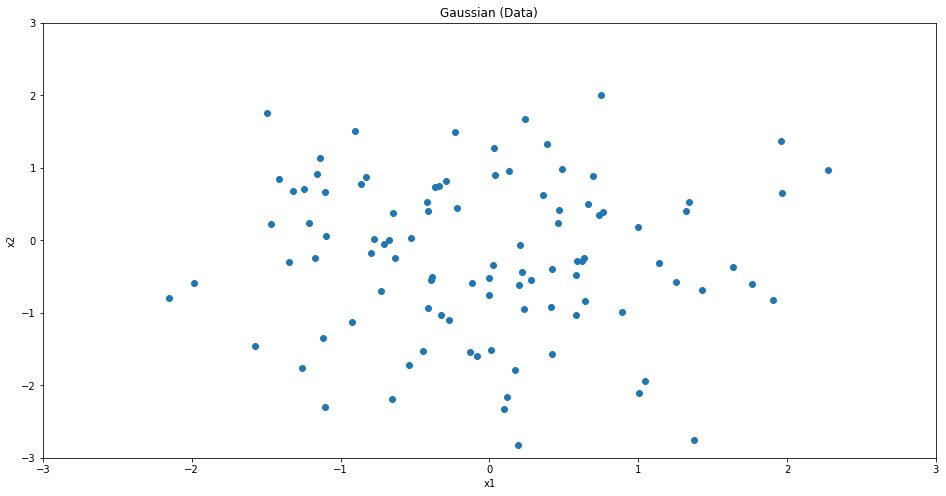

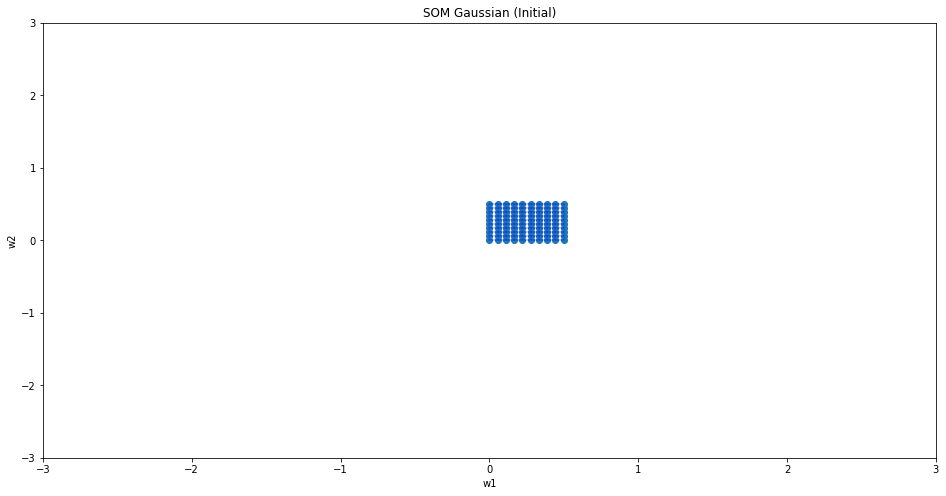

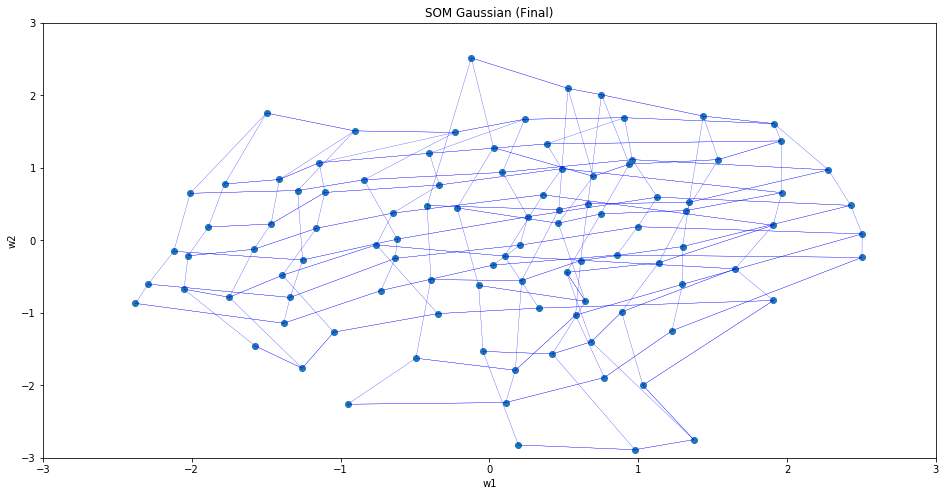

In [7]:
"""
    Plot Stuff
"""

# Uniform
plt.figure(figsize=(16,8))
plt.scatter(uniform[:,0],uniform[:,1])
plt.title('Uniform (Data)')
plt.xlabel('x1'); plt.ylabel('x2')
plt.xlim(-0.1,1.1); plt.ylim(-0.1,1.1);
plt.figure(figsize=(16,8))
plt.scatter(weight_uniform_initial.reshape(100,2)[:,0],weight_uniform_initial.reshape(100,2)[:,1])
plot_lattice(weight_uniform_initial)
plt.title('SOM Uniform (Initial)')
plt.xlabel('w1'); plt.ylabel('w2')
plt.xlim(-0.1,1.1); plt.ylim(-0.1,1.1); 
plt.figure(figsize=(16,8))
plt.scatter(weight_uniform.reshape(100,2)[:,0],weight_uniform.reshape(100,2)[:,1])
plot_lattice(weight_uniform)
plt.title('SOM Uniform (Final)')
plt.xlabel('w1'); plt.ylabel('w2')
plt.xlim(-0.1,1.1); plt.ylim(-0.1,1.1);  

# Gaussian
plt.figure(figsize=(16,8))
plt.scatter(gaussian[:,0],gaussian[:,1])
plt.title('Gaussian (Data)')
plt.xlabel('x1'); plt.ylabel('x2')
plt.xlim(-3,3); plt.ylim(-3,3);
plt.figure(figsize=(16,8))
plt.scatter(weight_gaussian_initial.reshape(100,2)[:,0],weight_gaussian_initial.reshape(100,2)[:,1])
plot_lattice(weight_gaussian_initial)
plt.title('SOM Gaussian (Initial)')
plt.xlabel('w1'); plt.ylabel('w2')
plt.xlim(-3,3); plt.ylim(-3,3); 
plt.figure(figsize=(16,8))
plt.scatter(weight_gaussian.reshape(100,2)[:,0],weight_gaussian.reshape(100,2)[:,1])
plot_lattice(weight_gaussian)
plt.title('SOM Gaussian (Final)')
plt.xlabel('w1'); plt.ylabel('w2')
plt.xlim(-3,3); plt.ylim(-3,3); 

# Show plots
plt.show()

###### Discussion

For both distributions, we can see that the SOM shifts its weights in order to match each random distribution over time. What's interesting to note is that there seems to be some overfitting of the SOM with respect to the original data. This can easily be seen in the uniform distribution map, where, in theory, the weights of the SOM should be evenly distributed across the range of a true uniform distribution. However, there are distortions in the map where the network seems to coalesce around concentrated examples. This can probably be fixed by having more samples in the original data, or by tuning the SOM further.